# <ins>"Определение перспективного тарифа для телеком компании"</ins>
___
В исходных файлах представленны нескелько таблиц, описывающих данные пользователей и тарифные планы, которые они используют, а также данные о звонках, сообщениях и интернет-трафике
### Содержание
___
<a id='top'></a>
1. [Постановка задачи](#1)
2. [Общая информация о данных](#2)
3. [Предобработка данных](#3)
 * 3.1 [Проверка на отрицательные значения](#3.1)
 * 3.2 [Проверка на дубликаты](#3.2)
 * 3.3 [Приведение данных к нужным типам](#3.3)
 * 3.4 [Исправление ошибок](#3.4)
 * 3.5 [Вычисление параметров для каждого пользователя](#3.5)
4. [Анализ](#4)
5. [Проверка гипотез](#5)
6. [Вывод](#6)

<a id='1'></a>

## 1. Постановка задачи
Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

<a id='2'></a>

## 2. Общая информация о данных

In [53]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [54]:
pd.set_option('display.max_columns', 30)

In [55]:
# прочитаем файлы:

df_tariffs = pd.read_csv('tariffs.csv')
df_users = pd.read_csv('users.csv')
df_calls = pd.read_csv('calls.csv')
df_messages = pd.read_csv('messages.csv')
df_internet = pd.read_csv('internet.csv')

In [56]:
df_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [57]:
df_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [58]:
df_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [59]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [60]:
df_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [61]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [62]:
df_messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [63]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [64]:
df_internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [65]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


В исходных файлах представленны нескелько таблиц, описывающих данные пользователей и тарифные планы, которые они используют, а также данные о звонках, сообщениях и интернет-трафике. Данные неоднородны по размеру. В некоторых таблицах есть пропуски, а так же типы данных в некоторых колонках неверны. Проведем предподготовку данных.

<a id='3'></a>
<a id='3.1'></a>

## 3. Предобработка данных
### 3.1 Проверка на отрицательные значения

Проверим на отрицательные значения все числовые данные из всех таблиц. Отрицательных быть не должно.

In [66]:
# список с таблицами где есть числовые значения
list_tables = [df_tariffs, df_users, df_calls, df_messages, df_internet]

# список с названиями тех же таблиц (нужно для вывода)
list_nametables = ['df_tariffs', 'df_users', 'df_calls', 'df_messages', 'df_internet']

# применим цикл перебирающий таблицы из первого списка, двигаемся по индексам списка
for i in range(0, len(list_tables)):
    print('-----------------------------')
    print('|{: <27}|'.format(list_nametables[i]))# печатаем название таблицы в которой идет проверка
    print('-----------------------------')
    
    # применим цикл перебирающий названия колонок в индексе метода dtype текущей таблицы
    for column_name in list_tables[i].dtypes.index:
        
        # если тип данных для колонки соответсвует int или float, то применим к ним проверку на отрицательные значения
        if list_tables[i][column_name].dtypes=='int64' or list_tables[i][column_name].dtypes=='float64':
            if list_tables[i][list_tables[i][column_name] < 0][column_name].count() > 0:
                print('|{: <22}|{: >4}|'.format(column_name, 'Есть'))
            else:
                print('|{: <22}|{: >4}|'.format(column_name, 'Нет'))
    print('-----------------------------')
    print()

-----------------------------
|df_tariffs                 |
-----------------------------
|messages_included     | Нет|
|mb_per_month_included | Нет|
|minutes_included      | Нет|
|rub_monthly_fee       | Нет|
|rub_per_gb            | Нет|
|rub_per_message       | Нет|
|rub_per_minute        | Нет|
-----------------------------

-----------------------------
|df_users                   |
-----------------------------
|user_id               | Нет|
|age                   | Нет|
-----------------------------

-----------------------------
|df_calls                   |
-----------------------------
|duration              | Нет|
|user_id               | Нет|
-----------------------------

-----------------------------
|df_messages                |
-----------------------------
|user_id               | Нет|
-----------------------------

-----------------------------
|df_internet                |
-----------------------------
|Unnamed: 0            | Нет|
|mb_used               | Нет|
|user_

Отрицательных значений нет.

<a id='3.2'></a>

### 3.2 Проверка на дубликаты

In [67]:
# воспользуемся списком таблиц из предыдущего цикла, двигаемся по индексам списка
for i in range(0, len(list_tables)):
    if list_tables[i].duplicated().sum() == 0:
        print('|{: <12}|{: >15}|'.format(list_nametables[i], 'дубликатов нет'))
    elif list_tables[i].duplicated().sum() != 0:
        print('|{: <12}|{: >15}|'.format(list_nametables[i], 'есть дубликаты'))

|df_tariffs  | дубликатов нет|
|df_users    | дубликатов нет|
|df_calls    | дубликатов нет|
|df_messages | дубликатов нет|
|df_internet | дубликатов нет|


<a id='3.3'></a>

### 3.3 Приведение данных к нужным типам

Рассмотрим каждую таблицу, приведем данные к нужным типам и обработаем пропуски где возможно.

**df_tariffs:**  
Все в порядке

**df_users:**  
Нужно привести колонки с датами к типу datetime. Т.к. в колонке churn_date очень много пропусков из-за того, что клиенты до сих пор пользуются тарифом, то привести ее к нужному типу не получится не избавившись от пропусков. Нам эта колонка в анализе не нужна, поэтому оставим и пропуски и тип данных как есть.

In [68]:
# применим метод pd.to_datetime чтобы привести временные данные в надлежащий вид

df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     object        
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


**df_calls:**  
Колонку с датами приведем к типу datetime.

In [69]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


**df_messages:**  
Колонку с датами приведем к типу datetime.

In [70]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


**df_internet:**  
Колонку с датами приведем к нужному типу.

In [71]:
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


<a id='3.4'></a>

### 3.4 Исправление ошибок

В таблице df_internet есть столбец "Unnamed: 0", который повторяет индексы строк. Его можно удалить.

In [72]:
del df_internet['Unnamed: 0']

In [73]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB


В датафрейме df_calls колонка с продолжительностью звонков содержит много нулевых значений.

In [74]:
df_calls[df_calls['duration']==0]['duration'].count()

39613

39613 это почти 20% от всех данных таблицы. Есть несколько размышлений:  
1. Это довольно большой объем данных чтобы просто удалить его.
2. Нулевые значения могут быть либо ошибками в данных, либо звонивший не смог дозвониться. Т.к. все остальные данные предоставленны почти без ошибок, то я склонен считать, что здесь тоже ошибки маловероятны, т.е. звонивший не смог дозвониться.
3. Наша задача - узнать какой тариф лучше. Поэтому я считаю, что для отдела коммерции более значимы данные с ненулевыми значениями, ведь тогда можно проводить различные оценки, считать суммы и прочее. А данные с нулевыми значениями более подходят для, например, технического отдела. Ведь ноль может быть звоночком, что с сетью что то не так и пользователи не могут совершить звонки.
4. Трудно принять какое-либо аргументированное решение плохо представляя предметную область и не имея возможности проконсультироваться с заказчиком.
5. Поэтому, т.к. в следющем разделе нам нужно будет посчитать количество звонков, я пока не буду удалять нулевые данные из таблицы. Возможно, это придется сделать при статистическом анализе, но там и посмотрим.

<a id='3.5'></a>

### 3.5 Вычисление параметров для каждого пользователя

Нам нужно посчитать для каждого пользователя следующие величины:  
 * количество сделанных звонков и израсходованных минут разговора по месяцам;
 * количество отправленных сообщений по месяцам;
 * объем израсходованного интернет-трафика по месяцам;
 * помесячную выручку с каждого пользователя.
 
Начнем с того, что добавим к каждой таблице колонку month, в которой будет отображен месяц совершения действия, чтобы потом можно было группировать по месяцам.

In [75]:
# определим переменную как список, в которм будет хранится название таблицы и колонки в ней, содержащей дату совершения действия
date_list = []

# нам нужны только три столбца со звонками, сообщениями и трафиком
# поэтому начинаем двигаться со второго индекса в списке таблиц
for i in range(2, len(list_tables)):
    
    # в списке колонок таблицы будем искать ту, у которой название заканчивается на 'date'
    # методом включения определенных символов в срез строки
    for j in range(0, len(list_tables[i].columns)):
        if 'date' in list_tables[i].columns[j][-4:]:
            date_list.append(list_tables[i].columns[j])
            
    # с помощью метода dt.month добавляем месяц в новую колонку 'month'
    list_tables[i]['month'] = list_tables[i][date_list[i-2]].dt.month

In [76]:
df_calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.00,1000,7
1,1000_1,2018-08-17,0.00,1000,8
2,1000_2,2018-06-11,2.85,1000,6
3,1000_3,2018-09-21,13.80,1000,9
4,1000_4,2018-12-15,5.18,1000,12


In [77]:
df_messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


In [78]:
df_internet.head()

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


**С помощью сводных таблиц рассчитаем необходимые параметры:**

Сгруппируем данные по user_id и month, применим методы к соответствующим значениям.

In [79]:
df_calls_pivot = df_calls.pivot_table(index=['user_id', 'month'], aggfunc={'call_date':'count', 'duration':sum}) 
df_calls_pivot.columns = ['calls_count', 'calls_duration']
df_calls_pivot.head()

calls_count  calls_duration
user_id month                             
1000    5               22          150.06
        6               43          158.90
        7               47          318.80
        8               52          389.87
        9               58          440.14

In [80]:
df_messages_pivot = df_messages.pivot_table(index=['user_id', 'month'], aggfunc={'id':'count'})
df_messages_pivot.columns = ['messages_count']
df_messages_pivot.head()

messages_count
user_id month                
1000    5                  22
        6                  60
        7                  75
        8                  81
        9                  57

In [81]:
df_internet_pivot = df_internet.pivot_table(index=['user_id', 'month'], aggfunc={'mb_used':sum})
df_internet_pivot.columns = ['traffic_volume']
df_internet_pivot.head()

traffic_volume
user_id month                
1000    5             2253.49
        6            23233.77
        7            14003.64
        8            14055.93
        9            14568.91

Для рассчета помесячной выручки объеденим все сводные таблицы и таблицу df_users

In [82]:
# при помощи метода join объеденим сразу все сводные таблицы по индексам
# и сбросим индекс month для последующего объединения с df_users

df_cmi_pivot = df_internet_pivot.join([df_calls_pivot, df_messages_pivot]).reset_index(level='month')
df_cmi_pivot.head(2)

,month,traffic_volume,calls_count,calls_duration,messages_count
user_id,,,,,
1000,5,2253.49,22.0,150.06,22.0
1000,6,23233.77,43.0,158.90,60.0


In [83]:
# объединяем df_users и df_cmi_pivot также методом join
# параметру 'on' передаем значения df_users['user_id']
# метод join будет искать совпадения этих значений с индексами df_cmi_pivot и объединять по ним

df_cmiu_pivot = df_users.join(df_cmi_pivot, on='user_id')
df_cmiu_pivot.head(2)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,traffic_volume,calls_count,calls_duration,messages_count
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,2253.49,22.0,150.06,22.0
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,23233.77,43.0,158.90,60.0


In [84]:
# удалим столбцы, которые нам не пригодятся чтобы легче было ориентироваться в таблице

df_cmiu_pivot = df_cmiu_pivot.drop(['churn_date', 'first_name', 'last_name', 'reg_date'], axis='columns')

In [85]:
# округлим значения продолжительности звонков и использованного трафика до целых чисел в большую сторону с помощью np.ceil():

df_cmiu_pivot['calls_duration'] = np.ceil(df_cmiu_pivot['calls_duration'])
df_cmiu_pivot['traffic_volume'] = np.ceil(df_cmiu_pivot['traffic_volume'])
df_cmiu_pivot.head()

,user_id,age,city,tariff,month,traffic_volume,calls_count,calls_duration,messages_count
0,1000,52,Краснодар,ultra,5.0,2254.0,22.0,151.0,22.0
0,1000,52,Краснодар,ultra,6.0,23234.0,43.0,159.0,60.0
0,1000,52,Краснодар,ultra,7.0,14004.0,47.0,319.0,75.0
0,1000,52,Краснодар,ultra,8.0,14056.0,52.0,390.0,81.0
0,1000,52,Краснодар,ultra,9.0,14569.0,58.0,441.0,57.0


In [86]:
# добавим к df_cmiu_pivot информацию о тарифах из таблицы df_tariffs
# объединим таблицы по колонке с названиями тарифов
# для этого сначала в df_tariffs поменяем название нужного столбца на tariff

df_tariffs.columns = ['messages_included', 'mb_per_month_included', 'minutes_included', 'rub_monthly_fee',\
                      'rub_per_gb', 'rub_per_message', 'rub_per_minute', 'tariff']
df_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [87]:
# применим метод merge, параметру "on" передадим колонку с названиями тарифов, параметр "how" по умолчанию "inner"

df_cmiu_pivot = df_cmiu_pivot.merge(df_tariffs, on='tariff')
df_cmiu_pivot.head()

,user_id,age,city,tariff,month,traffic_volume,calls_count,calls_duration,messages_count,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,Краснодар,ultra,5.0,2254.0,22.0,151.0,22.0,1000,30720,3000,1950,150,1,1
1,1000,52,Краснодар,ultra,6.0,23234.0,43.0,159.0,60.0,1000,30720,3000,1950,150,1,1
2,1000,52,Краснодар,ultra,7.0,14004.0,47.0,319.0,75.0,1000,30720,3000,1950,150,1,1
3,1000,52,Краснодар,ultra,8.0,14056.0,52.0,390.0,81.0,1000,30720,3000,1950,150,1,1
4,1000,52,Краснодар,ultra,9.0,14569.0,58.0,441.0,57.0,1000,30720,3000,1950,150,1,1


После объединения таблиц образовалось немало пропусков, особенно в messages_count. Это произошло из-за разницы в исходных данных (см. "Общая информация о данных"). Оставить как есть или отбросить их не вариант, т.к. в первом случае они повляют на дальнейшие расчеты, а во втором потеряем много данных. Поэтому заменим все пропуски на ноль.

In [88]:
# проверим на пропуски получившийся датафрейм

df_cmiu_pivot.isnull().sum()

user_id                    0
age                        0
city                       0
tariff                     0
month                      3
traffic_volume             3
calls_count               43
calls_duration            43
messages_count           500
messages_included          0
mb_per_month_included      0
minutes_included           0
rub_monthly_fee            0
rub_per_gb                 0
rub_per_message            0
rub_per_minute             0
dtype: int64

In [89]:
# пропуски в колонке month заменить на ноль нельзя, всего три строки с пропусками, поэтому удалим их

df_cmiu_pivot[df_cmiu_pivot['month'].isnull()]

,user_id,age,city,tariff,month,traffic_volume,calls_count,calls_duration,messages_count,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
243,1128,51,Волжский,ultra,NaN,NaN,NaN,NaN,NaN,1000,30720,3000,1950,150,1,1
477,1273,46,Курган,ultra,NaN,NaN,NaN,NaN,NaN,1000,30720,3000,1950,150,1,1
2610,1371,50,Омск,smart,NaN,NaN,NaN,NaN,NaN,50,15360,500,550,200,3,3


In [90]:
df_cmiu_pivot = df_cmiu_pivot.dropna(subset=['month'])

In [91]:
df_cmiu_pivot[df_cmiu_pivot['month'].isnull()]

,user_id,age,city,tariff,month,traffic_volume,calls_count,calls_duration,messages_count,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute


In [92]:
# остальные пропуски заменим на ноль

df_cmiu_pivot = df_cmiu_pivot.fillna(0)

In [93]:
df_cmiu_pivot.isnull().sum()

user_id                  0
age                      0
city                     0
tariff                   0
month                    0
traffic_volume           0
calls_count              0
calls_duration           0
messages_count           0
messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
dtype: int64

Рассчитаем помесячную выручку при помощи функции total_bill_monthly, в которой в качестве pd.Series будет выступать строка датафрейма.

In [94]:
def total_bill_monthly(row):
    
# определим переменные
    
    bill_minutes = 0
    bill_sms = 0
    bill_traffic = 0
    minutes = row['calls_duration']
    sms = row['messages_count']
    traffic = row['traffic_volume']
    tariff = row['tariff']
    minutes_limit = row['minutes_included']
    sms_limit = row['messages_included']
    traffic_limit = row['mb_per_month_included']
    monthly_fee = row['rub_monthly_fee']
    rub_per_gb = row['rub_per_gb']
    rub_per_message = row['rub_per_message']
    rub_per_minute = row['rub_per_minute']

# проверим разницу между суммарными значениями звонков, сообщений, трафика и бесплатным лимитом тарифа
# если эта разница меньше нуля, то возвращаем ноль - клиент не израсходовал бесплатный лимит
# если больше - то разницу умножаем на стоимость сверх тарифного плана
    
    if minutes > minutes_limit:
        bill_minutes += (minutes - minutes_limit) * rub_per_minute
    if minutes < minutes_limit:
        bill_minutes = 0
    if sms > sms_limit:
        bill_sms += (sms - sms_limit) * rub_per_message
    if sms < sms_limit:
        bill_sms = 0
    if traffic > traffic_limit:
        bill_traffic += (np.ceil((traffic - traffic_limit) / 1024 )) * rub_per_gb# округляем мегабайты вверх до гигабайт
    if traffic < traffic_limit:
        bill_traffic = 0
        
# функция возвращает итоговый счет за месяц для клиента,
# в котором к сумме счетов за отдельные категории услуг прибавляется абонентская плата за тариф
        
    return bill_minutes + bill_sms + bill_traffic + monthly_fee

In [95]:
# применим функцию к датафрейму
# метод apply() применяем в нашем случае ко всему датафрейму
# Чтобы на вход в функцию отправлялись строки, указываем параметр axis = 1 метода apply()

df_cmiu_pivot['total_bill'] = df_cmiu_pivot.apply(total_bill_monthly, axis=1)
df_cmiu_pivot

,user_id,age,city,tariff,month,traffic_volume,calls_count,calls_duration,messages_count,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,total_bill
0,1000,52,Краснодар,ultra,5.0,2254.0,22.0,151.0,22.0,1000,30720,3000,1950,150,1,1,1950.0
1,1000,52,Краснодар,ultra,6.0,23234.0,43.0,159.0,60.0,1000,30720,3000,1950,150,1,1,1950.0
2,1000,52,Краснодар,ultra,7.0,14004.0,47.0,319.0,75.0,1000,30720,3000,1950,150,1,1,1950.0
3,1000,52,Краснодар,ultra,8.0,14056.0,52.0,390.0,81.0,1000,30720,3000,1950,150,1,1,1950.0
4,1000,52,Краснодар,ultra,9.0,14569.0,58.0,441.0,57.0,1000,30720,3000,1950,150,1,1,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3201,1498,68,Владикавказ,smart,10.0,20580.0,41.0,233.0,42.0,50,15360,500,550,200,3,3,1750.0
3202,1499,35,Пермь,smart,9.0,1846.0,9.0,65.0,11.0,50,15360,500,550,200,3,3,550.0
3203,1499,35,Пермь,smart,10.0,17789.0,68.0,430.0,48.0,50,15360,500,550,200,3,3,1150.0
3204,1499,35,Пермь,smart,11.0,17964.0,74.0,577.0,59.0,50,15360,500,550,200,3,3,1408.0


<a id='4'></a>

## 4. Анализ

**Чтобы посмотреть поведение клиентов посчитаем помесячную сумму исследуемых параметров для всех пользователей:**

In [96]:
df_month_sum = (df_cmiu_pivot
                .pivot_table(index=['tariff', 'month'],
                             values=['calls_count', 'calls_duration', 'messages_count', 'traffic_volume', 'total_bill'],
                             aggfunc=sum))

df_month_sum = df_month_sum.reset_index(level='month')
df_month_sum

,month,calls_count,calls_duration,messages_count,total_bill,traffic_volume
tariff,,,,,,
smart,1.0,941.0,6579.0,620.0,24456.0,289482.0
smart,2.0,2331.0,16438.0,1397.0,47053.0,672656.0
smart,3.0,4183.0,28362.0,2453.0,87384.0,1163058.0
smart,4.0,5747.0,38838.0,3443.0,105253.0,1507817.0
smart,5.0,7789.0,51565.0,4762.0,165339.0,2228598.0
smart,6.0,9110.0,61283.0,5478.0,192950.0,2590405.0
smart,7.0,11402.0,77587.0,6784.0,239765.0,3164469.0
smart,8.0,13856.0,93569.0,7904.0,302467.0,3903634.0
smart,9.0,15482.0,105303.0,8746.0,316187.0,4239065.0


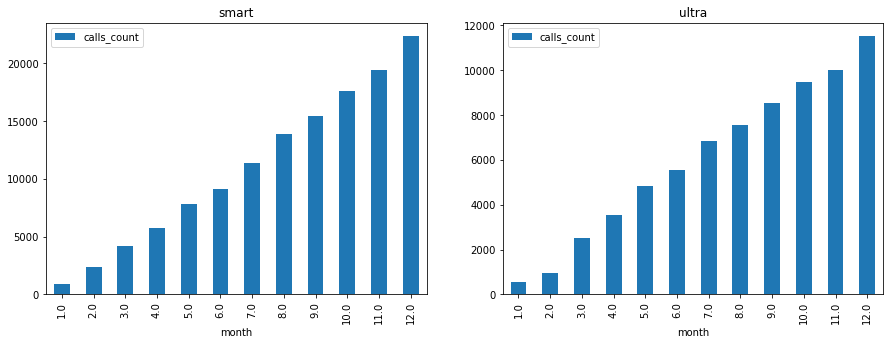

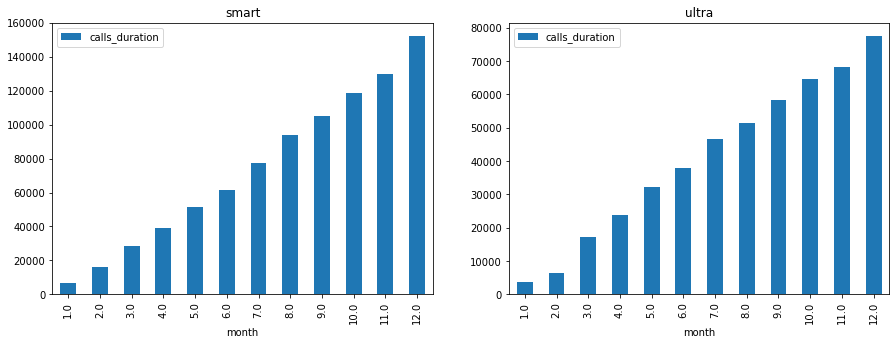

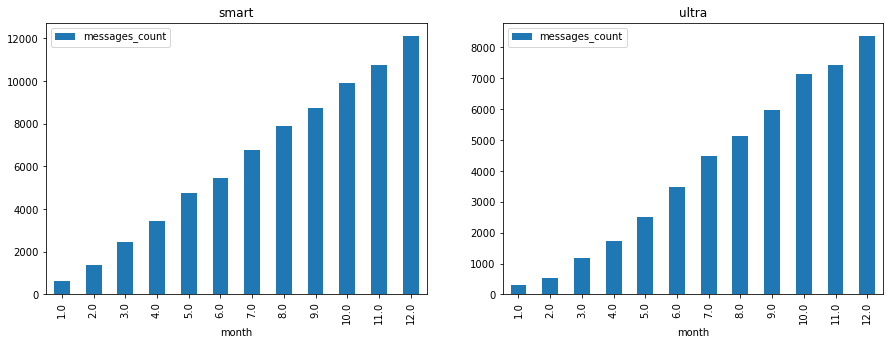

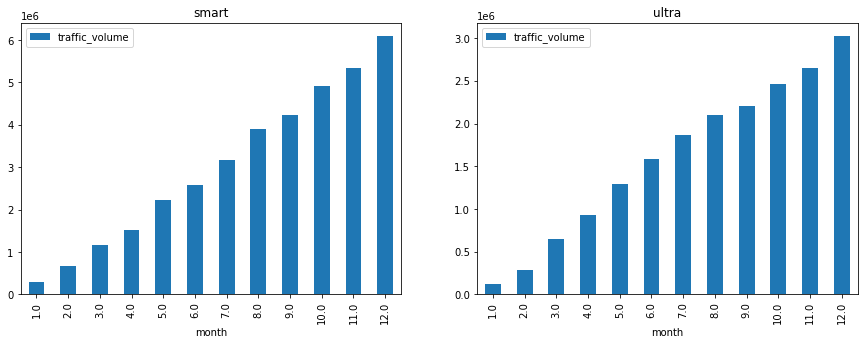

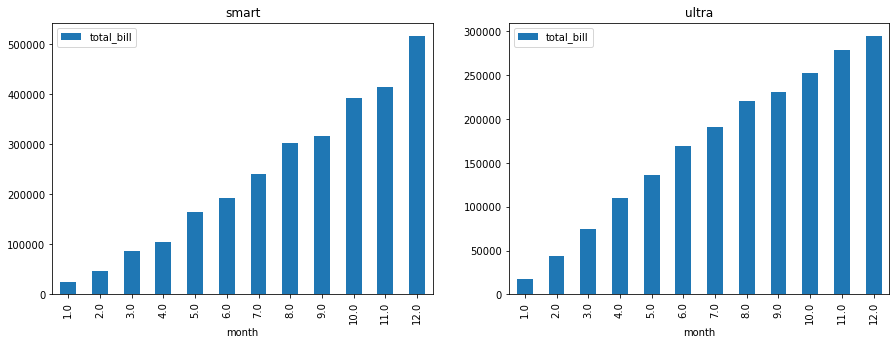

In [97]:
# для большей наглядности построим столбчатые графики распределения суммарных значений параметров в течение года:

for dms_col_name in ['calls_count', 'calls_duration', 'messages_count', 'traffic_volume', 'total_bill']:
    fig, axs = plt.subplots(1,2)
    df_month_sum[df_month_sum.index=='smart'].plot(x='month', y=dms_col_name, kind='bar', title='smart', ax=axs[0], figsize=(15, 5))
    df_month_sum[df_month_sum.index=='ultra'].plot(x='month', y=dms_col_name, kind='bar', title='ultra', ax=axs[1], figsize=(15, 5))

На количественные показатели здесь можно не смотреть, т.к. объем выборок разный:

In [98]:
df_cmiu_pivot[df_cmiu_pivot['tariff']=='smart']['tariff'].count()

2228

In [99]:
df_cmiu_pivot[df_cmiu_pivot['tariff']=='ultra']['tariff'].count()

975

А вот поведение клиентов в течение рассматриваемого периода времени графики показывают очень хорошо:  
как видим все параметры (количество звонков, продолжительность разговоров, количество сообщений, объем израсходованного интернет-трафика и ежемесячный счет) растут о января к декабрю, причем растут довольно таки линейно и не зависимо от того, какой тариф используют клиенты.  
Январь и декабрь еще могу объяснить - в январе много отдыхают семьями и не до звонков, а в декабре все аврально завершают дела и поздравляют близких. Постепенный и устойчивый рост между этими двумя месяцами объяснить не могу.

**Посчитаем среднее, дисперсию и стандартное отклонение для всех пользователей в течение всего периода:**  
Применим цикл, в котором с помощью сводных таблиц раассчитаем необходимые параметры.

In [100]:
for i in range(0, 3):
    functions = ['mean', np.var, np.std]# функции, которые будем применять к значениям
    tables = ['total_month_sum_mean', 'total_month_sum_var', 'total_month_sum_std']# названия сводных таблиц
    list_of_cols = ['calls_duration', 'messages_count', 'traffic_volume', 'total_bill']# значения
    suffix = ['_mean', '_var', '_std']# суффикс, который добавим к именам колонок
    
    tables[i] = df_cmiu_pivot.pivot_table(index=['tariff'], values=list_of_cols, aggfunc=functions[i])
    tables[i].columns = ['calls_duration'+suffix[i], 'messages_count'+suffix[i],\
                         'traffic_volume'+suffix[i], 'total_bill'+suffix[i]]
    display(tables[i])

,calls_duration_mean,messages_count_mean,traffic_volume_mean,total_bill_mean
tariff,,,,
smart,395.078546,33.398564,1257.906194,16216.148564
ultra,500.517949,49.585641,2071.384615,19668.993846


,calls_duration_var,messages_count_var,traffic_volume_var,total_bill_var
tariff,,,,
smart,32353.071062,796.69963,641528.913064,3.436001e+07
ultra,89957.083610,2301.92464,142819.949455,9.886460e+07


,calls_duration_std,messages_count_std,traffic_volume_std,total_bill_std
tariff,,,,
smart,179.869595,28.225868,800.955001,5861.741292
ultra,299.928464,47.978377,377.915268,9943.067706


В среднем пользователи тарифа ультра больше пользуются услугами оператора, чем пользователи тарифа смарт.

Однако рассеяние вокруг среднего значения у ультра также выше, кроме параметра интернет-трафик. Тут можно выделить два момента:  
 * 1. большая дисперсия у ультра можно объяснить меньшим объемом выборки, чем у смарт;
 * 2. меньшая дисперсия в интрнет-трафике говорит  о том, что возможно пользователи выбирают тариф ультра из-за большого включенного пакета мегабайт трафика, т.к. сейчас в основном большая часть звонков и сообщений передается посредством сети интрнет. Т.о. пользователи ультра не заботятся об экономии трафика и используют его свободно, что приводит к среднему с меньшим разбросом. В то время как пользователи смарт экономно используют свой лимит и в итоге к концу месяца у многих оставшийся трафик сгорает, а у некоторых, кто "забылся" и не следил за лимитом, - перерасход.

**Посмотрим какое количество пользователей тратит то или иное количество предоставленных услуг. Для этого построим частотные гистограммы:**

In [101]:
# сгруппируем данных сводной таблицей по тарифу и пользователям:
cmit_sum_for_hist = (df_cmiu_pivot
                     .pivot_table(index=['tariff', 'user_id'],\
                                  values=['calls_count', 'calls_duration', 'messages_count', 'traffic_volume', 'total_bill'],\
                                  aggfunc=sum))

# расставим столбцы в удобном порядке:
cols = cmit_sum_for_hist.columns.tolist()
cols = cols[:3] + cols[-1:] + cols[-2:4]
cmit_sum_for_hist = cmit_sum_for_hist[cols]

cmit_sum_for_hist.reset_index(inplace=True)

cmit_sum_for_hist

,tariff,user_id,calls_count,calls_duration,messages_count,traffic_volume,total_bill
0,smart,1001,122.0,801.0,0.0,32467.0,1700.0
1,smart,1002,217.0,1434.0,70.0,116041.0,7250.0
2,smart,1005,888.0,6248.0,552.0,99692.0,9045.0
3,smart,1006,506.0,3296.0,0.0,164194.0,10250.0
4,smart,1007,612.0,4143.0,225.0,131631.0,7867.0
...,...,...,...,...,...,...,...
492,ultra,1476,549.0,3981.0,45.0,150290.0,17550.0
493,ultra,1485,94.0,548.0,155.0,23423.0,1950.0
494,ultra,1491,648.0,4353.0,432.0,161466.0,17550.0
495,ultra,1493,110.0,702.0,94.0,54421.0,5700.0


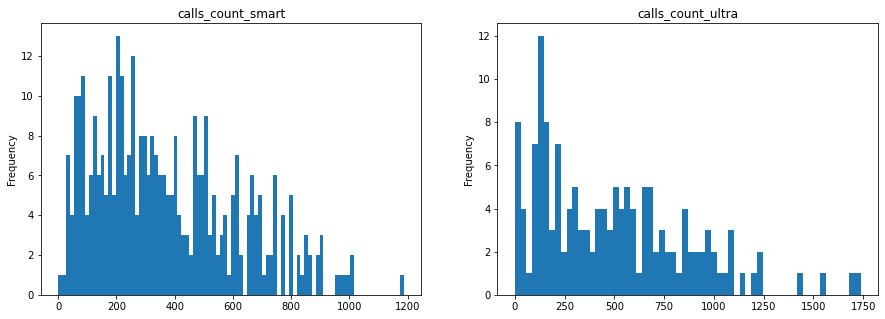

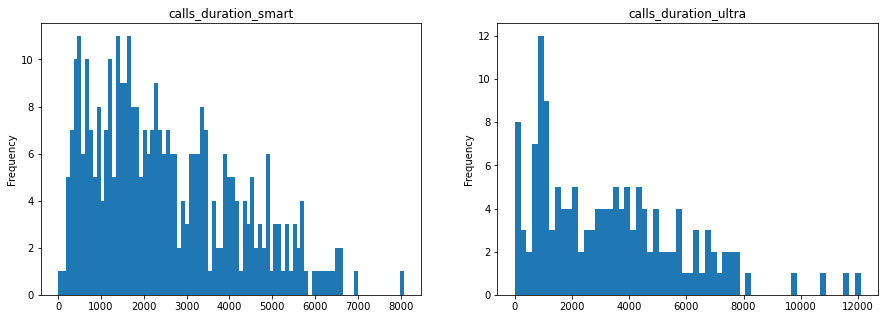

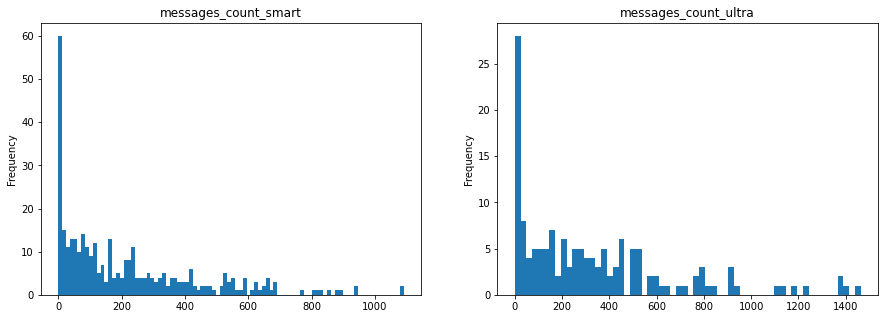

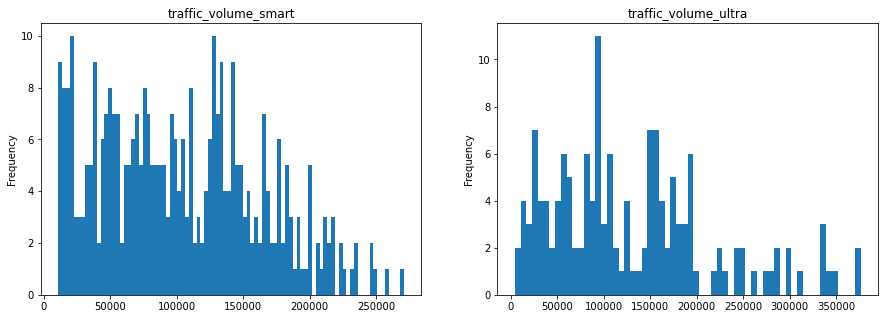

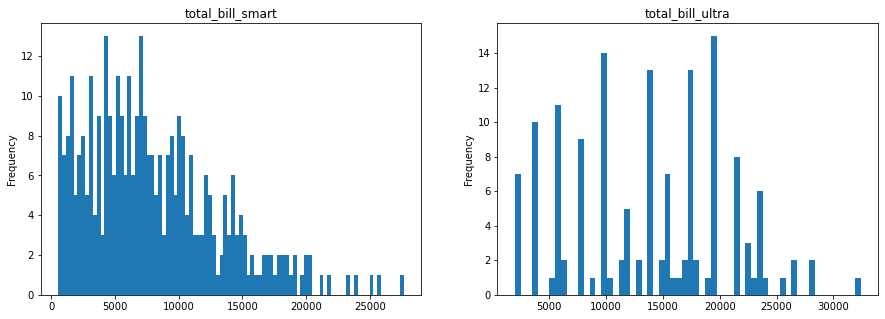

In [102]:
# гистограммы построим при помощи цикла рядом друг с другом, чтобы было проще сравнивать тарифы

for csfh_name_column in cmit_sum_for_hist.columns[2:]:
    fig, axs = plt.subplots(1,2)
    cmit_sum_for_hist[cmit_sum_for_hist['tariff']=='smart'][csfh_name_column].plot(bins=90, kind='hist', figsize=(15, 5), title=csfh_name_column+'_smart', ax=axs[0])
    cmit_sum_for_hist[cmit_sum_for_hist['tariff']=='ultra'][csfh_name_column].plot(bins=60, kind='hist', figsize=(15, 5), title=csfh_name_column+'_ultra', ax=axs[1])

В силу большей дисперсии ультра имеет более длинные хвосты чем смарт.
* 1. Количество звонков: Пик у смарт приходится на 200, у ультра - около 130.
* 2. Продолжительность звонков: У смарт наблюдается два основных пика около 400 и 1500 минут, у ультра один - около 1000. В основном люди тарифа смарт говорят не больше 6000 минут в год, в то время как клиенты ультра почти 8000 минут. Также видим, что у ультра есть небольшой пик на околонулевых значениях (0 - 250).
* 3. Количество сообщений: В обоих тарифах высока доля людей крайне мало использующих смс. При этом следует помнить, что ранее мы заменили 500 пропусков в датафрейме нулями и сейчас наблюдаем результаты этого действия. Но в любом случае все сейчас пользуются месенджерами.
* 4. Интернет-трафик: У обоих тарифов наблюдается четкая граница в районе 200000 мб, после которой совсем мало значений. Пик у ультра в районе 100000 мб, у смарт два пика - один в районе 20000, другой около 130000 мб.
* 5. Итоговый счет: Т.к. пользователи подключались в разное время года и не все оставались на одном тарифе до конца мы видим, что большая часть трат на связь находится до уровня минимальной годовой абонентской платы, которая для смарт составляет 6600, а для ультра 23400. У смарт второй пик находится в районе 7500, после чего идет плавное уменьшение числа людей перерасходовавших траифный план, т.е. большая часть людей хоть немного, но перерасходует тарифные лимиты. У ультра большинство пользователей тратит до 20000, после чего есть еще одна граница в районе 23000-24000, после чего небольшой хвост, т.е. пользователя тарифа ультра в основном укладываются в лимиты тарифного плана и не перерасходуют его.

<a id='5'></a>

## 5. Проверка гипотез

**Первая гипотеза**

Первая гипотеза которую нужно проверить - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

Сформулируем нулевую и альтернативную гипотезы:
* H0 - средняя выручка пользователей тарифов «Ультра» и «Смарт» равны (в H0 всегда используется знак равенства);
* H1 - средние выручки пользователей тарифов «Ультра» и «Смарт» различаются.

Чтобы проверить гипотезу о равенстве среднего применим метод scipy.stats.ttest_ind (array1, array2, equal_var), где equal_var - параметр, задающий считать ли равными дисперсии выборок. Передаётся как "equal_var = True" или "equal_var = False" (True — считать, False — не считать). Т.к. мы знаем, что дисперсии выборок по смарт и ультра различаются (3.436001e+07 и 9.886460e+07 соответственно), то equal_var зададим как False.

In [103]:
smart_ttest = df_cmiu_pivot[df_cmiu_pivot['tariff']=='smart']['total_bill']
ultra_ttest = df_cmiu_pivot[df_cmiu_pivot['tariff']=='ultra']['total_bill']

# уровень значимости зададим равным 5%
alpha = 0.05

results = st.ttest_ind(smart_ttest, ultra_ttest, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.1678550574171129e-272
Отвергаем нулевую гипотезу


p-уровень значимости слишком мал, гораздо меньше определенного нами порогового значения в 5% => средняя выручка пользователей тарифов смарт и ульра значимо отличаются друг от друга.

**Вторая гипотеза**

Вторая гипотеза для проверки звучит так - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

* Н0 - средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов;
* Н1 - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Альтернативная гипотеза у нас двусторонняя, т.к. средняя выручка из Москвы может отличаться от других регионов как в большую так и в меньшую сторону.

Для проверки гипотезы воспользуемся методом scipy.stats.ttest_1samp (array, popmean), где в качестве массива данных будет выборка выручки по москвичам, а в качестве popmean (предполагаемого среднего, на равенство которому мы делаем тест) будет выступать среднее значение выручки пользователей из других регионов.

In [104]:
moscow_ttest = df_cmiu_pivot[df_cmiu_pivot['city']=='Москва']['total_bill']

popmean = df_cmiu_pivot[df_cmiu_pivot['city']!='Москва']['total_bill'].mean()

# уровень значимости 5%
alpha = 0.05

results = st.ttest_1samp(moscow_ttest, popmean)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.3859979276331743
Не получилось отвергнуть нулевую гипотезу


р-уровень значимости составил почти 39%, что значительно выше 5% => средняя выручка по Москве статистически значимо не отличается от средней выручки по другим регионам.

<a id='6'></a>

## 6. Вывод

Сделав предварительный анализ тарифов на небольшой выборке пользователей можем передать следующие результаты коммерческому отделу:
 * Средние чеки тарифов смарт и ультра **значимо** различаются. В среднем пользователи тарифа ультра платят больше;
 * Т.к. средняя выручка по москве и другим регионам **значимо** не различаются, то рекламную компанию можно устроить по всей территории распространения сети;
 * Поведение клиентов в течение года очень хорошо отображено на графиках. Эти графики будут полезны чтобы скорректировать во времени рекламные компании.